In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

# 1. Regression

In [69]:
# Columns
NUMERICAL_COLS = [
    'crim',
    'zn',
    'nox',
    'rooms',
    'age',
    'dis',
    'rad',
    'tax',
    'ptratio',
    'b',
    'lstat'
]

NO_TRANSFORM = ['river'] # binary

### 1. Scaling

In [70]:
class DataTransformer:
    def fit(self, df):
        self.scalers = {}
        for col in NUMERICAL_COLS:
            scaler = StandardScaler()
            scaler.fit(df[col].as_matrix().reshape(-1, 1))
            self.scalers[col] = scaler
            
    def transform(self, df):
        N, _   = df.shape
        D = len(NUMERICAL_COLS) + len(NO_TRANSFORM)
        X = np.zeros((N,D))
        i = 0
        
        for col, scaler in self.scalers.items():
            X[:, i] = scaler.transform(df[col].as_matrix().reshape(-1, 1)).flatten()
            i += 1
        
        for col in NO_TRANSFORM:
            X[:, i] = df[col]
            i += 1
        return X
    
    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

### 2. Data

In [73]:
def get_data():
    # regex allows arbitrary number of spaces in seperator
    df = pd.read_csv('./housing.data.txt', header=None, sep=r'\s*', engine='python')
    df.columns = [
        'crim', 'zn', 'nonretail', 'river', 'nox', 'rooms',
        'age', 'dis', 'rad', 'tax', 'ptratio', 'b', 'lstat', 'medv'
    ]
    
    #transformer
    transformer = DataTransformer()
    
    #shuffle the data
    N = len(df)
    train_idx = np.random.choice(N, size=int(0.7*N), replace=False)
    test_idx = [i for i in range(N) if i not in train_idx]
    df_train = df.loc[train_idx]
    df_test = df.loc[test_idx]
    
    Xtrain = transformer.fit_transform(df_train)
    Ytrain = np.log(df_train['medv'].as_matrix())
    Xtest = transformer.transform(df_test)
    Ytest = np.log(df_test['medv'].as_matrix())
    return Xtrain, Ytrain, Xtest, Ytest

In [74]:
Xtrain, Ytrain, Xtest, Ytest = get_data()

C:\Users\sailyourlife\Anaconda3\lib\site-packages\pandas\io\parsers.py:2138: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
C:\Users\sailyourlife\Anaconda3\lib\site-packages\pandas\io\parsers.py:2140: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
C:\Users\sailyourlife\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [15]:
model = RandomForestRegressor(n_estimators=100)
model.fit(Xtrain, Ytrain)
predictions = model.predict(Xtest)

ymin: 2.0 ymax: 4.0


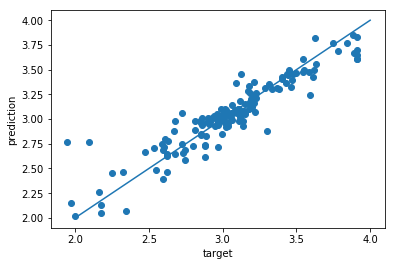

In [16]:
plt.scatter(Ytest, predictions)
plt.xlabel("target")
plt.ylabel("prediction")
ymin = np.round( min( min(Ytest), min(predictions) ) )
ymax = np.ceil( max( max(Ytest), max(predictions) ) )
print("ymin:", ymin, "ymax:", ymax)
r = range(int(ymin), int(ymax) + 1)
plt.plot(r, r)
plt.show()

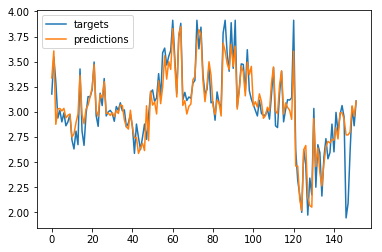

In [17]:
plt.plot(Ytest, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

In [18]:
# do a quick baseline test
baseline = LinearRegression()
single_tree = DecisionTreeRegressor()
print("CV single tree:", cross_val_score(single_tree, Xtrain, Ytrain).mean())
print("CV baseline:", cross_val_score(baseline, Xtrain, Ytrain).mean())
print("CV forest:", cross_val_score(model, Xtrain, Ytrain).mean())

CV single tree: 0.652439350139
CV baseline: 0.759265811312
CV forest: 0.820718641346


In [19]:
# test score
single_tree.fit(Xtrain, Ytrain)
baseline.fit(Xtrain, Ytrain)
print("test score single tree:", single_tree.score(Xtest, Ytest))
print("test score baseline:", baseline.score(Xtest, Ytest))
print("test score forest:", model.score(Xtest, Ytest))

test score single tree: 0.765645614045
test score baseline: 0.798194267224
test score forest: 0.854643910259


# 2. Classification

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [21]:
NUMERICAL_COLS = ()
CATEGORICAL_COLS = np.arange(22) + 1 # 1..22 inclusive

### Data Encoder

In [60]:
class DataTransformer:
    def fit(self, df):
        self.labelEncoders = {}
        self.scalers = {}
        
        # numerical
        for col in NUMERICAL_COLS:
            scaler = StandardScaler()
            scaler.fit(df[col].reshape(-1, 1))
            self.scalers[col] = scaler
            
        # categorical
        for col in CATEGORICAL_COLS:
            encoder = LabelEncoder()
            
            # in case the train set does not have 'missing value but test set does
            values = df[col].tolist()
            values.append('missing')
            encoder.fit(values)
            self.labelEncoders[col] = encoder
            
        # find dimensionality
        self.D = len(NUMERICAL_COLS)
        for col, encoder in self.labelEncoders.items():
            self.D += len(encoder.classes_)
        print("dimensionality: ", self.D)
        
    def transform(self, df):
        N, _ = df.shape
        X = np.zeros((N, self.D))
        i = 0
        
        # put data in X
        for col, scaler in self.scalers.items():
            X[:,i] = scaler.transform(df[col].as_matrix().reshape(-1, 1)).flatten()
            i += 1
        
        for col, encoder in self.labelEncoders.items():
            K = len(encoder.classes_)
            X[np.arange(N), encoder.transform(df[col]) + i] = 1
            i += K
        return X
    
    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)

### Missing value

In [61]:
def replace_missing(df):
    # standard method of replacement for numerical columns is median
    
    for col in NUMERICAL_COLS:
        if np.any(df[col].isnull()):
            # median replacing
            med = np.median(df[col][df[col].notnull()])
            df.loc[df[col].isnull(), col] = med
            
    # set a special value = 'missing'
    for col in CATEGORICAL_COLaS:
        if np.any(df[col].isnull()):
            print(col)
            df.loc[df[col].isnull(), col] = 'missing'

### Get data

In [62]:
def get_data():
    df = pd.read_csv('./agaricus-lepiota.data.txt', header=None)
       
    # replace label column: e/p --> 0/1
    df[0] = df.apply(lambda row: 0 if row[0] =='e' else 1, axis=1)
    
    # missing data
    replace_missing(df)

    # transform data
    transformer = DataTransformer()
    
    X = transformer.fit_transform(df)
    Y = df[0].as_matrix()
    return X, Y

In [63]:
X, Y = get_data()

dimensionality:  139


In [64]:
# do a quick baseline test
baseline = LogisticRegression()
print("CV baseline:", cross_val_score(baseline, X, Y, cv=8).mean())

# single tree
tree = DecisionTreeClassifier()
print("CV one tree:", cross_val_score(tree, X, Y, cv=8).mean())

model = RandomForestClassifier(n_estimators=20) # try 10, 20, 50, 100, 200
print("CV forest:", cross_val_score(model, X, Y, cv=8).mean())

CV baseline: 0.927480630115
CV one tree: 0.942642110469
CV forest: 0.956188666072
